In [2]:
# 5001 NCF推荐系统

In [12]:
# 数据预处理及模型搭建

In [25]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.layers import (Embedding, Flatten, Dense, Concatenate, Input, 
                                     Dropout, Lambda, BatchNormalization)
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt


# 1. 数据导入与预处理
df = pd.read_csv('/Users/weihermans/Documents/nus_learning_documents/Practice Moudle/5001_model_save/features.csv')
original_df = df.copy()  # 备份原始数据

# 1.1 连续特征标准化
continuous_features = ['price', 'number_of_reviews', 'review_scores_rating']
scaler = StandardScaler()
df[continuous_features] = scaler.fit_transform(df[continuous_features])

# 1.2 分类特征独热编码
categorical_features = ['geographical_location', 'purpose', 'Number_of_people', 'surroundings', 'transportation', 'room_type', 'host_is_superhost']
df = pd.get_dummies(df, columns=categorical_features)

# 1.3 唯一key进行LabelEncoder
encoder_reviewer = LabelEncoder()
df['reviewer_id'] = encoder_reviewer.fit_transform(df['reviewer_id'])
encoder_listing = LabelEncoder()
df['listing_id'] = encoder_listing.fit_transform(df['listing_id'])


#  1.4 选择包含bool类型的列
bool_columns = df.select_dtypes(include=[bool]).columns
# 将这些列转换为float
df[bool_columns] = df[bool_columns].astype(float)



# 2. 模型搭建
embedding_dim = 10
n_users = df['reviewer_id'].nunique()
n_items = df['listing_id'].nunique()

# 2.1 用户和物品嵌入层，添加正则化
user_input = Input(shape=(1,), name="user_input")
user_embedding = Embedding(n_users, embedding_dim, embeddings_regularizer=l2(1e-4))(user_input)
user_vector = Flatten()(user_embedding)

item_input = Input(shape=(1,), name="item_input")
item_embedding = Embedding(n_items, embedding_dim, embeddings_regularizer=l2(1e-4))(item_input)
item_vector = Flatten()(item_embedding)

# 2.2 合并连续和分类特征输入
combined_features = continuous_features + [col for col in df.columns if any((cat + "_") in col for cat in categorical_features)]
combined_input = Input(shape=(len(combined_features),), name="combined_input")
dense_vector = Dense(128, activation='relu')(combined_input)

# 2.3 合并所有特征向量
all_vectors = [user_vector, item_vector, dense_vector]
concat = Concatenate()(all_vectors)

# 定义深层神经网络，并为其添加一个残差连接
residual = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(concat)
residual = BatchNormalization()(residual)

dense = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(residual)
dense = BatchNormalization()(dense)
dense = Dropout(0.2)(dense)
dense = Dense(64, activation='relu')(dense)
dense = BatchNormalization()(dense)

# 添加跳跃连接
dense = Concatenate()([dense, residual])
outputs = Dense(1, activation='sigmoid')(dense)
outputs = Lambda(lambda x: x * 4 + 1)(outputs)  # 将输出从[0,1]缩放到[1,5]

# 2.5 构建并编译模型
all_inputs = [user_input, item_input, combined_input]
model = Model(inputs=all_inputs, outputs=outputs)

# 学习率衰减
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer, loss='mean_squared_error')
model.summary()


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 user_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 item_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 embedding_8 (Embedding)     (None, 1, 10)                288720    ['user_input[0][0]']          
                                                                                                  
 embedding_9 (Embedding)     (None, 1, 10)                14820     ['item_input[0][0]']          
                                                                                            

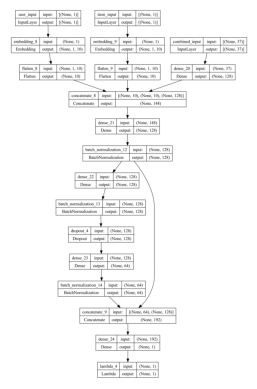

In [26]:
from tensorflow.keras.utils import plot_model

# 可视化模型
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
plt.imshow(plt.imread('model.png'))
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()


In [ ]:
# 训练和评估模型

Epoch 1/100
703/703 [==============================] - 2s 2ms/step - loss: 3.4832 - val_loss: 2.6925
Epoch 2/100
703/703 [==============================] - 1s 2ms/step - loss: 2.4942 - val_loss: 2.2475
Epoch 3/100
703/703 [==============================] - 1s 2ms/step - loss: 2.1250 - val_loss: 1.9294
Epoch 4/100
703/703 [==============================] - 1s 2ms/step - loss: 1.8322 - val_loss: 1.6771
Epoch 5/100
703/703 [==============================] - 1s 2ms/step - loss: 1.5853 - val_loss: 1.4707
Epoch 6/100
703/703 [==============================] - 1s 2ms/step - loss: 1.3653 - val_loss: 1.3246
Epoch 7/100
703/703 [==============================] - 1s 2ms/step - loss: 1.1505 - val_loss: 1.2156
Epoch 8/100
703/703 [==============================] - 1s 2ms/step - loss: 0.9532 - val_loss: 1.1009
Epoch 9/100
703/703 [==============================] - 1s 2ms/step - loss: 0.7988 - val_loss: 1.0196
Epoch 10/100
703/703 [==============================] - 1s 2ms/step - loss: 0.6743 - val_lo

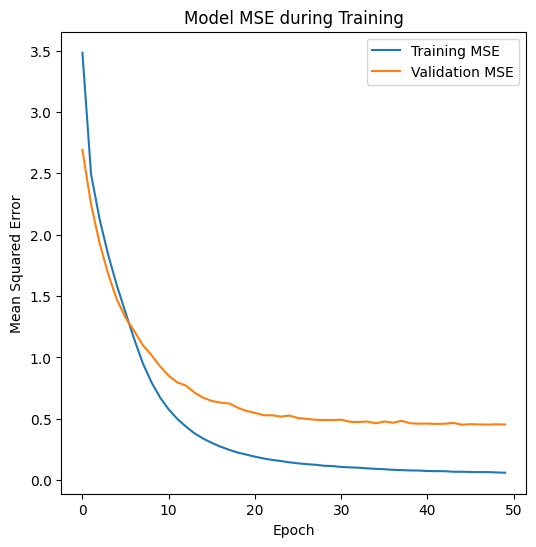

In [28]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 准备模型输入数据
combined_features_input = df[combined_features].values

X = [
    df['reviewer_id'].values,
    df['listing_id'].values,
    combined_features_input
]
y = df['scores'].values

# 1. 划分训练和测试集
X_train_list = []
X_test_list = []

for feature in X:
    X_train_feature, X_test_feature = train_test_split(feature, test_size=0.2, random_state=42)
    X_train_list.append(X_train_feature)
    X_test_list.append(X_test_feature)

y_train, y_test = train_test_split(y, test_size=0.2, random_state=42)

# 2. 添加EarlyStopping回调函数
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)


# 3. 训练模型并捕获历史记录
history = model.fit(X_train_list, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stop])

# 4. 使用测试集评估模型
loss = model.evaluate(X_test_list, y_test)
print(f"Test MSE: {loss}")

rmse = tf.math.sqrt(loss)
print(f"Test RMSE: {rmse.numpy()}")

# 5. 可视化MSE
plt.figure(figsize=(6, 6))
plt.plot(history.history['loss'], label='Training MSE')
plt.plot(history.history['val_loss'], label='Validation MSE')
plt.title('Model MSE during Training')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()


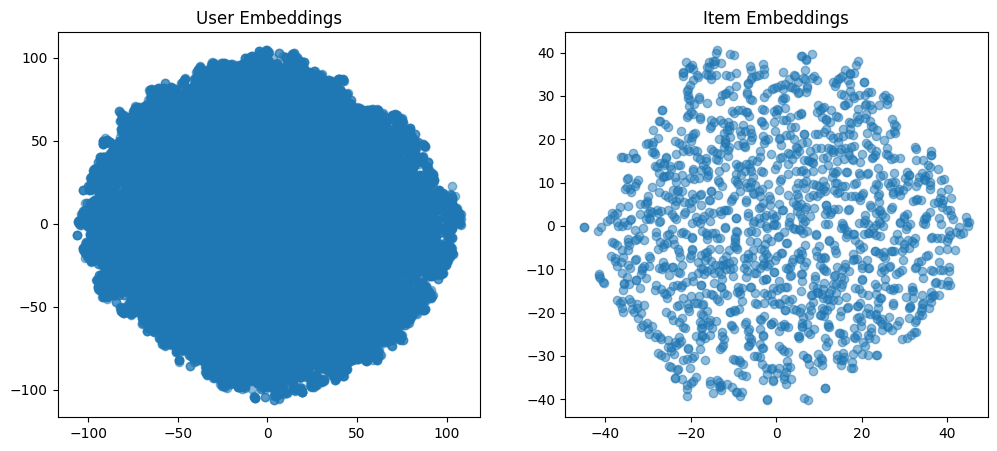

In [23]:
from sklearn.manifold import TSNE

# 获取嵌入权重
user_embeddings = model.get_layer('embedding_6').get_weights()[0]
item_embeddings = model.get_layer('embedding_7').get_weights()[0]

# 使用t-SNE降维
user_embeddings_tsne = TSNE(n_components=2).fit_transform(user_embeddings)
item_embeddings_tsne = TSNE(n_components=2).fit_transform(item_embeddings)

# 可视化嵌入
plt.figure(figsize=(12, 5))

# 用户嵌入可视化
plt.subplot(1, 2, 1)
plt.scatter(user_embeddings_tsne[:, 0], user_embeddings_tsne[:, 1], alpha=0.5)
plt.title('User Embeddings')

# 物品嵌入可视化
plt.subplot(1, 2, 2)
plt.scatter(item_embeddings_tsne[:, 0], item_embeddings_tsne[:, 1], alpha=0.5)
plt.title('Item Embeddings')

plt.show()


In [29]:
save_directory = '/Users/weihermans/Documents/nus_learning_documents/Practice Moudle/5001_model_save/'

# Save the model
model.save(save_directory + '5001_NCF_model.h5')
print(f"Model saved to {save_directory + '5001_NCF_model.h5'}!")

import joblib
# Save the scaler
joblib.dump(scaler, save_directory + 'scaler.pkl')
print(f"scaler.pkl saved to {save_directory + 'scaler.pkl'}!")

# Save the label encoders
joblib.dump(encoder_reviewer, save_directory + 'encoder_reviewer.pkl')
print(f"encoder_reviewer.pkl saved to {save_directory + 'encoder_reviewer.pkl'}!")
joblib.dump(encoder_listing, save_directory + 'encoder_listing.pkl')
print(f"encoder_listing.pkl saved to {save_directory + 'encoder_listing.pkl'}!")

# Save the continuous_features, categorical_features and combined_features lists
joblib.dump(continuous_features, save_directory + 'continuous_features.pkl')
print(f"continuous_features.pkl saved to {save_directory + 'continuous_features.pkl'}!")
joblib.dump(categorical_features, save_directory + 'categorical_features.pkl')
print(f"categorical_features.pkl saved to {save_directory + 'categorical_features.pkl'}!")
joblib.dump(combined_features, save_directory + 'combined_features.pkl')
print(f"combined_features.pkl saved to {save_directory + 'combined_features.pkl'}!")


Model saved to /Users/weihermans/Documents/nus_learning_documents/Practice Moudle/5001_model_save/5001_NCF_model.h5!
scaler.pkl saved to /Users/weihermans/Documents/nus_learning_documents/Practice Moudle/5001_model_save/scaler.pkl!
encoder_reviewer.pkl saved to /Users/weihermans/Documents/nus_learning_documents/Practice Moudle/5001_model_save/encoder_reviewer.pkl!
encoder_listing.pkl saved to /Users/weihermans/Documents/nus_learning_documents/Practice Moudle/5001_model_save/encoder_listing.pkl!
continuous_features.pkl saved to /Users/weihermans/Documents/nus_learning_documents/Practice Moudle/5001_model_save/continuous_features.pkl!
categorical_features.pkl saved to /Users/weihermans/Documents/nus_learning_documents/Practice Moudle/5001_model_save/categorical_features.pkl!
combined_features.pkl saved to /Users/weihermans/Documents/nus_learning_documents/Practice Moudle/5001_model_save/combined_features.pkl!


/Users/weihermans/miniconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
